In [3]:
#!pip install xgboost

In [4]:
import sys
import os
sys.path.append("../") 
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
from exploratory_data_analysis import omnivida_loader as ov
from exploratory_data_analysis import omnivida_util as ovu
import statsmodels.api         as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from io import StringIO
from IPython.display import Image, SVG
from graphviz import Source
from sklearn.tree import export_graphviz
import pydotplus
import xgboost as xgb
from xgboost import XGBClassifier

In [5]:
#Allow full dataset display:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [6]:
#Load datasets:
pathologics = ov.get_pathological_record_dataset()
adherence, adherence_change=ov.get_adherence_dataset()
hospitalizations = ov.get_hospitalizations_dataset()
emergencies=ov.get_emergencies_dataset()

In [7]:
#Set the correct data types:
#Adherence_change:
adherence_change['category'] = adherence_change['category'].astype('category')
adherence_change['category'].cat.reorder_categories(['N', 'N+', 'M', 'A-', 'A'], ordered=True, inplace=True)
adherence_change['qualitative_result'] = adherence_change['qualitative_result'].astype(int)
adherence_change['qualitative_result_change'] = adherence_change['qualitative_result_change'].fillna(0)
adherence_change['qualitative_result_change'] = adherence_change['qualitative_result_change'].astype(int)
adherence_change['ongoing_adherence_percentage'] = adherence_change['ongoing_adherence_percentage'].astype(int)
select_fields = ['id_patient', 'survey_date', 'category', 'qualitative_result', 'qualitative_result_change', 'days_since_last_control', 'ongoing_adherence_percentage', 'num_reports']
adherence_change_analysis = adherence_change[select_fields]

#Emergencies:
emergencies.drop(columns={'Unnamed: 0','diagnosis'}, inplace=True, axis=1)
emergencies.description_service.unique()
emergencies.loc[emergencies['description_service']=='ATENCION MEDICA PRIORITARIA', 'description_service'] = 1
emergencies.loc[emergencies['description_service']=='CONSULTA MEDICO GENERAL NO PROGRAMADA', 'description_service'] = 0
emergencies['description_service'] = emergencies['description_service'].astype(int)
emergencies['regional_health_provider'] = emergencies['regional_health_provider'].astype('category')
emergencies['code_service'] = emergencies['code_service'].astype('category')
emergencies['diagnosis_code'] = emergencies['diagnosis_code'].astype('category')
emergencies['registration_date']=pd.to_datetime(emergencies['registration_date'])

#Pathologics:
pathologics.rename(columns={'diagnosis_code': 'pathologics_diagnosis_code'}, inplace=True)
# pathologics.drop(columns=['end_date'], axis=1, inplace=True)
pathologics['pathologics_diagnosis_code'] = pathologics['pathologics_diagnosis_code'].astype('category')
pathologics['health_provider'] = pathologics['health_provider'].astype('category')

#Hospitalizations:
hospitalizations.rename(columns={'diagnosis_code': 'hospitalizations_diagnosis_code'}, inplace=True)
hospitalizations.drop(columns=['gender', 'age'], axis=1, inplace=True)
hospitalizations['in_date']=pd.to_datetime(hospitalizations['in_date'])
hospitalizations['out_date']=pd.to_datetime(hospitalizations['out_date'])

In [8]:
#Merge:
merged_adherence = adherence_change_analysis.merge(emergencies, how='left', on='id_patient')
merged_adherence = merged_adherence.merge(pathologics, how='left', on='id_patient')
merged_adherence = merged_adherence.merge(hospitalizations, how='left', on='id_patient')

In [9]:
#Reorder the dataset:
cols= list(merged_adherence.columns.values);
new_oder= [0, 1, 9, 14, 15, 21, 2,3,4,5,6,7,8,10,11,12,13,16,17,18,19,20,22];
merged_adherence_1=merged_adherence[merged_adherence.columns[new_oder]];

In [10]:
#Sort the dataset by dates:
merged_adherence_1.sort_values(by=['id_patient',
                               'survey_date',
                               'registration_date',
                               'update_date',
                               'start_date','in_date'],ascending=True);

In [11]:
merged_adherence_1.info();
cols1= list(merged_adherence_1.columns.values);
merged_adherence_1[['id_patient','qualitative_result','qualitative_result_change','days_since_last_control','ongoing_adherence_percentage','num_reports','description_service','icu_days','scu_days','days']]=merged_adherence_1[['id_patient','qualitative_result','qualitative_result_change','days_since_last_control','ongoing_adherence_percentage','num_reports','description_service','icu_days','scu_days','days']].fillna(0)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 496329 entries, 0 to 496328
Data columns (total 23 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   id_patient                       496329 non-null  int64         
 1   survey_date                      496329 non-null  datetime64[ns]
 2   registration_date                491566 non-null  datetime64[ns]
 3   update_date                      496318 non-null  datetime64[ns]
 4   start_date                       491482 non-null  datetime64[ns]
 5   in_date                          482745 non-null  datetime64[ns]
 6   category                         496329 non-null  category      
 7   qualitative_result               496329 non-null  int64         
 8   qualitative_result_change        496329 non-null  int64         
 9   days_since_last_control          457749 non-null  float64       
 10  ongoing_adherence_percentage     496329 non-

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Text(0.5,1,'Correlation Matrix')

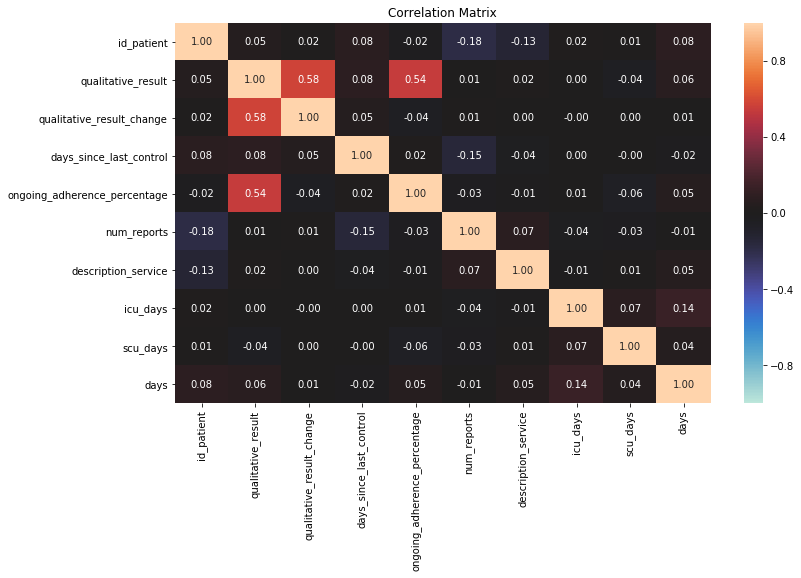

In [12]:
corr_merged_adherence_1 = merged_adherence_1.corr()
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_merged_adherence_1, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

In [13]:

#Part 1.
adherence_change_hospitalizations = ovu.merge_on_closest_date(df1=adherence_change_analysis, df2=hospitalizations, date_field_df1='survey_date', date_field_df2='in_date', merge_on='id_patient')
adherence_change_hospitalizations.rename(columns={'days_since_in_date': 'days_since_last_hospitalization'}, inplace=True)
period = 30
aclq_timely = adherence_change_hospitalizations[adherence_change_hospitalizations.days_since_last_hospitalization <= period]
aclq_late = adherence_change_hospitalizations[adherence_change_hospitalizations.days_since_last_hospitalization > period]
aclq_timely

,id_patient,survey_date,category,qualitative_result,qualitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,days_since_last_hospitalization,hospitalizations_diagnosis_code,icu_days,scu_days,days,in_date,out_date,cod_diagnostico
7,502989,2014-11-21,M,0,0,24.0,0,3,16.0,M131,0,0,13,2014-11-05,2014-11-18,NaN
39,524006,2015-01-05,A-,1,0,NaN,100,1,21.0,R104,0,0,2,2014-12-15,2014-12-17,R104
49,524006,2017-07-28,A-,1,1,79.0,72,11,18.0,L512,0,0,4,2017-07-10,2017-07-14,NaN
63,535255,2013-04-12,A,1,0,56.0,100,2,1.0,J019,0,0,8,2013-04-11,2013-04-19,NaN
79,535255,2019-11-30,A,1,0,44.0,94,18,19.0,A91X,0,0,8,2019-11-11,2019-11-19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,1862248,2016-02-15,A-,0,-1,54.0,50,2,19.0,NaN,0,0,5,2016-01-27,2016-02-01,J189
2135,1862248,2019-04-12,A-,1,0,149.0,85,7,14.0,E840,0,0,2,2019-03-29,2019-03-31,NaN
2146,1884922,2015-10-14,M,1,0,26.0,100,4,16.0,R521,0,0,1,2015-09-28,2015-09-29,NaN
2188,1923816,2019-01-10,N+,1,0,203.0,100,2,0.0,J459,0,0,4,2019-01-10,2019-01-14,J459


In [14]:
#Part 2.
aclq_timely_summary = pd.DataFrame()
for (patient, survey_date), df in aclq_timely.groupby(['id_patient', 'survey_date']):
    aclq_timely_summary = aclq_timely_summary.append({
        'id_patient': patient,
        'survey_date': survey_date,
        'num_hospitalizations_last_30_days': df.shape[0],
        'total_days': df.days.sum(),
        'days_since_last_hospitalization': df.iloc[-1]['days_since_last_hospitalization']
    }, ignore_index=True)

In [15]:
aclq_timely_summary;

In [16]:
#Part 3.
hosp_patho_emer_adherence = merged_adherence_1.merge(aclq_timely_summary, how='left', on=['id_patient', 'survey_date'])
#Part 4.
hosp_patho_emer_adherence['total_days'] = hosp_patho_emer_adherence['total_days'].fillna(0)
hosp_patho_emer_adherence['num_hospitalizations_last_30_days'] = hosp_patho_emer_adherence['num_hospitalizations_last_30_days'].fillna(0)
hosp_patho_emer_adherence['days_since_last_hospitalization'] = hosp_patho_emer_adherence['days_since_last_hospitalization'].fillna(0)

In [17]:
#hosp_patho_emer_adherence.info();

In [18]:
# Part 1.

adherence_change_emergencies= ovu.merge_on_closest_date(df1=adherence_change_analysis, df2=emergencies, date_field_df1='survey_date', date_field_df2='registration_date', merge_on='id_patient')
adherence_change_emergencies.rename(columns={'days_since_registration_date': 'days_since_last_emergency'}, inplace=True)
period = 30
aclq_timely_e = adherence_change_emergencies[adherence_change_emergencies.days_since_last_emergency <= period]
aclq_late_e = adherence_change_emergencies[adherence_change_emergencies.days_since_last_emergency > period]
aclq_timely_e

# Part 2.

aclq_timely_e_summary = pd.DataFrame()
for (patient, survey_date), df in aclq_timely_e.groupby(['id_patient', 'survey_date']):
    aclq_timely_e_summary = aclq_timely_e_summary.append({
        'id_patient': patient,
        'survey_date': survey_date,
        'num_emergencies_last_30_days': df.shape[0],
        'days_since_last_emergency': df.iloc[-1]['days_since_last_emergency']
    }, ignore_index=True)
    
# Part 3.

hosp_patho_emer_adherence_2 = hosp_patho_emer_adherence.merge(aclq_timely_e_summary, how='left', on=['id_patient', 'survey_date'])

# Part 4.

hosp_patho_emer_adherence_2['days_since_last_emergency'] = hosp_patho_emer_adherence_2['days_since_last_emergency'].fillna(0)
hosp_patho_emer_adherence_2['num_emergencies_last_30_days'] = hosp_patho_emer_adherence_2['num_emergencies_last_30_days'].fillna(0)
hosp_patho_emer_adherence_2['days_since_last_hospitalization'] = hosp_patho_emer_adherence_2['days_since_last_hospitalization'].fillna(0)

In [19]:
hosp_patho_emer_adherence_2.drop(columns=['category', 'qualitative_result_change'], axis=1, inplace=True)


# Get a copy of the previous dataset to encode the features

ho_pa_em_ad_modelable = hosp_patho_emer_adherence_2.copy()
ho_pa_em_ad_modelable['regional_health_provider'] = ho_pa_em_ad_modelable['regional_health_provider'].cat.codes
ho_pa_em_ad_modelable['diagnosis_code'] = ho_pa_em_ad_modelable['diagnosis_code'].cat.codes
ho_pa_em_ad_modelable['health_provider'] = ho_pa_em_ad_modelable['health_provider'].cat.codes
ho_pa_em_ad_modelable['pathologics_diagnosis_code'] = ho_pa_em_ad_modelable['pathologics_diagnosis_code'].cat.codes
ho_pa_em_ad_modelable['hospitalizations_diagnosis_code'] = ho_pa_em_ad_modelable['hospitalizations_diagnosis_code'].cat.codes
ho_pa_em_ad_modelable['code_service'] = ho_pa_em_ad_modelable['code_service'].cat.codes

Text(0.5,1,'Correlation Matrix')

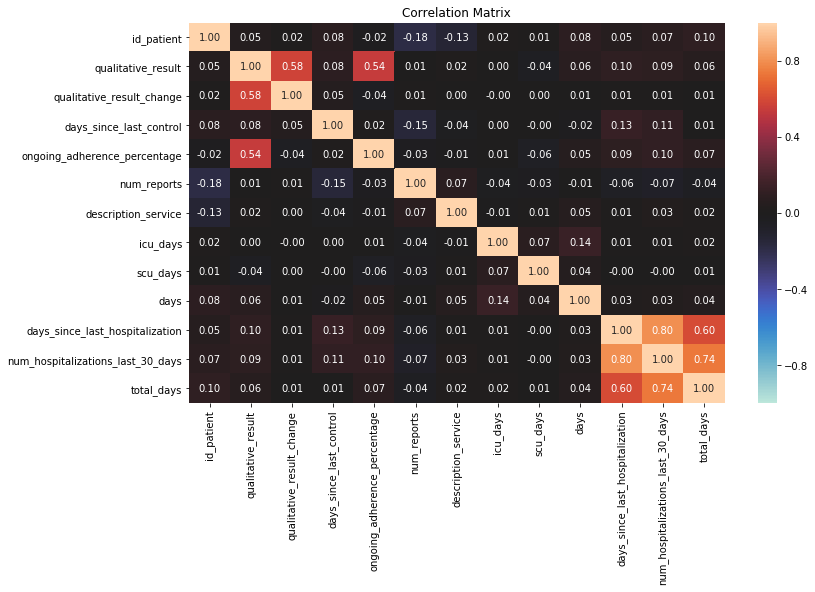

In [20]:
corr_hosp_patho_emer_adherence = hosp_patho_emer_adherence.corr()
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_hosp_patho_emer_adherence, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

Text(0.5,1,'Correlation Matrix')

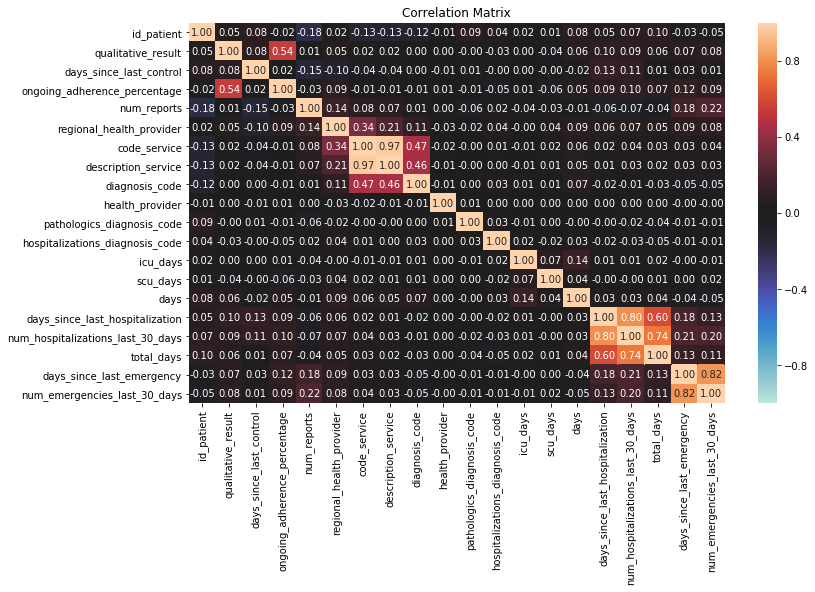

In [21]:
corr_ho_pa_em_ad_modelable = ho_pa_em_ad_modelable.corr()
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_ho_pa_em_ad_modelable, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

# Model Training:

In [22]:
def train(self):
    """Train two models: one Random forest classifier and one based on XGBoost"""
    if not self.rforest and not self.xgboost:
        covariates = self.data.columns[~self.data.columns.isin(['id_patient', 'qualitative_result', 'survey_date', 'birthdate', 'num_reports'])]
        print('> Training Random Forest classifier...')
        self.rforest = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0)
        self.rforest.fit(self.data[covariates], self.data['qualitative_result'])
        y_pred_rf = self.rforest.predict(self.data[covariates])
        accuracy_rf = accuracy_score(self.data['qualitative_result'], y_pred_rf)
        print("> Done. Accuracy: %.2f%%" % (accuracy_rf * 100.0))

        print('> Training XGBoost classifier...')
        params={
            'reg_alpha': 23, 
            'max_depth': 8, 
            'learning_rate': 0.01, 
            'gamma': 1.0
        }
        self.xgboost = XGBClassifier(random_state=0, booster='gbtree', **params)
        self.xgboost.fit(self.data[covariates], self.data['qualitative_result'])
        y_pred_xg = self.xgboost.predict(self.data[covariates])
        predictions_xg = [round(value) for value in y_pred_xg]
        accuracy_xg = accuracy_score(self.data['qualitative_result'], predictions_xg)
        print("> Done. Accuracy: %.2f%%" % (accuracy_xg * 100.0))

    return (self.rforest, self.xgboost)

# Model using all covariates:

In [23]:
ho_pa_em_ad_modelable

,id_patient,survey_date,registration_date,update_date,start_date,in_date,qualitative_result,days_since_last_control,ongoing_adherence_percentage,num_reports,regional_health_provider,code_service,description_service,diagnosis_code,health_provider,pathologics_diagnosis_code,hospitalizations_diagnosis_code,icu_days,scu_days,days,out_date,days_since_last_hospitalization,num_hospitalizations_last_30_days,total_days,days_since_last_emergency,num_emergencies_last_30_days
0,500547,2016-07-11,2019-06-13,2016-08-04,2014-10-22,2015-10-04,1,0.0,100,1,6,0,0.0,2,1,247,227,0.0,0.0,3.0,2015-10-07,0.0,0.0,0.0,0.0,0.0
1,500547,2016-07-11,2019-06-13,2016-08-04,2014-10-22,2015-10-07,1,0.0,100,1,6,0,0.0,2,1,247,227,0.0,0.0,7.0,2015-10-14,0.0,0.0,0.0,0.0,0.0
2,500547,2016-07-11,2019-06-13,2019-03-14,2015-05-05,2015-10-04,1,0.0,100,1,6,0,0.0,2,1,222,227,0.0,0.0,3.0,2015-10-07,0.0,0.0,0.0,0.0,0.0
3,500547,2016-07-11,2019-06-13,2019-03-14,2015-05-05,2015-10-07,1,0.0,100,1,6,0,0.0,2,1,222,227,0.0,0.0,7.0,2015-10-14,0.0,0.0,0.0,0.0,0.0
4,500547,2016-07-11,2019-01-04,2016-08-04,2014-10-22,2015-10-04,1,0.0,100,1,6,0,0.0,323,1,247,227,0.0,0.0,3.0,2015-10-07,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496324,1999629,2018-10-08,2019-02-06,2010-12-02,2010-08-01,NaT,1,157.0,100,3,6,1,1.0,28,1,177,-1,0.0,0.0,0.0,NaT,0.0,0.0,0.0,0.0,0.0
496325,1999629,2018-10-08,2019-02-06,2010-12-02,2002-12-01,NaT,1,157.0,100,3,6,1,1.0,28,1,153,-1,0.0,0.0,0.0,NaT,0.0,0.0,0.0,0.0,0.0
496326,1999629,2018-10-08,2019-02-06,2010-12-02,2010-12-02,NaT,1,157.0,100,3,6,1,1.0,28,1,153,-1,0.0,0.0,0.0,NaT,0.0,0.0,0.0,0.0,0.0
496327,1999629,2018-10-08,2019-02-06,2010-12-02,2010-12-02,NaT,1,157.0,100,3,6,1,1.0,28,1,177,-1,0.0,0.0,0.0,NaT,0.0,0.0,0.0,0.0,0.0


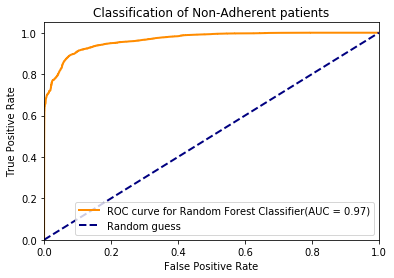

In [24]:
#Model using all covariates:

covariates1 = ho_pa_em_ad_modelable.columns[~ho_pa_em_ad_modelable.columns.isin(['id_patient', 
                                                                                 'qualitative_result',
                                                                                 'registration_date',
                                                                                 'update_date',
                                                                                 'start_date',
                                                                                 'in_date',
                                                                                 'out_date',
                                                                                 'survey_date'])]
depth = 7

clf = DecisionTreeClassifier(max_depth = depth)
clf = clf.fit(ho_pa_em_ad_modelable[covariates1], ho_pa_em_ad_modelable['qualitative_result'])

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf.fit(ho_pa_em_ad_modelable[covariates1], ho_pa_em_ad_modelable['qualitative_result'])
clf_rf_probas = clf_rf.predict_proba(ho_pa_em_ad_modelable[covariates1])

roc_p = roc_curve(ho_pa_em_ad_modelable['qualitative_result'], clf_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_p:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Non-Adherent patients')
plt.legend(loc='lower right')
plt.show()

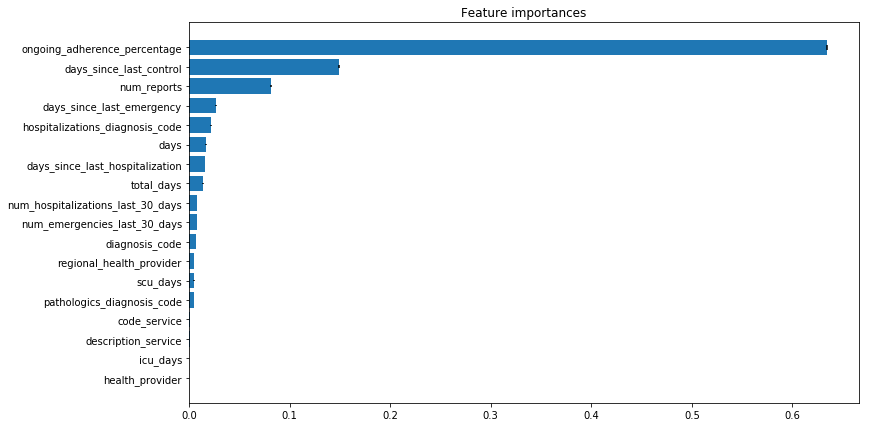

In [25]:
importances = clf_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(12,7))
plt.title("Feature importances")
plt.barh(ho_pa_em_ad_modelable[covariates1].columns[indices], importances[indices], yerr=std[indices], align="center")
plt.show()

# Model using all covariates but num_reports and ongoing_adherence_percentage.

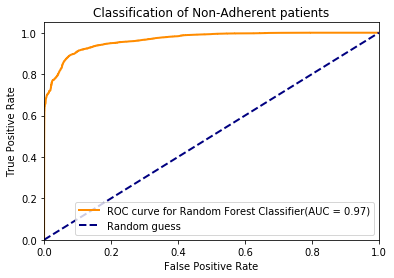

In [26]:
#Model using all covariates but num_reports and ongoing_adherence_percentage.

covariates2 = ho_pa_em_ad_modelable.columns[~ho_pa_em_ad_modelable.columns.isin(['id_patient', 
                                                                                 'qualitative_result',
                                                                                 'registration_date',
                                                                                 'update_date',
                                                                                 'start_date',
                                                                                 'in_date',
                                                                                 'out_date',
                                                                                 'survey_date',
                                                                                'num_reports',
                                                                                'ongoing_adherence_percentage'])]
depth = 7

clf2 = DecisionTreeClassifier(max_depth = depth)
clf2 = clf.fit(ho_pa_em_ad_modelable[covariates2], ho_pa_em_ad_modelable['qualitative_result'])

clf_rf2 = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf2.fit(ho_pa_em_ad_modelable[covariates2], ho_pa_em_ad_modelable['qualitative_result'])
clf_rf_probas2 = clf_rf2.predict_proba(ho_pa_em_ad_modelable[covariates2])

roc_p2 = roc_curve(ho_pa_em_ad_modelable['qualitative_result'], clf_rf_probas[:,1])
auc_p2 = auc_p2 = auc( roc_p2[0], roc_p2[1] )

plt.figure()
line_width = 2
plt.plot(roc_p2[0], roc_p2[1], color='darkorange', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_p2:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Non-Adherent patients')
plt.legend(loc='lower right')
plt.show()

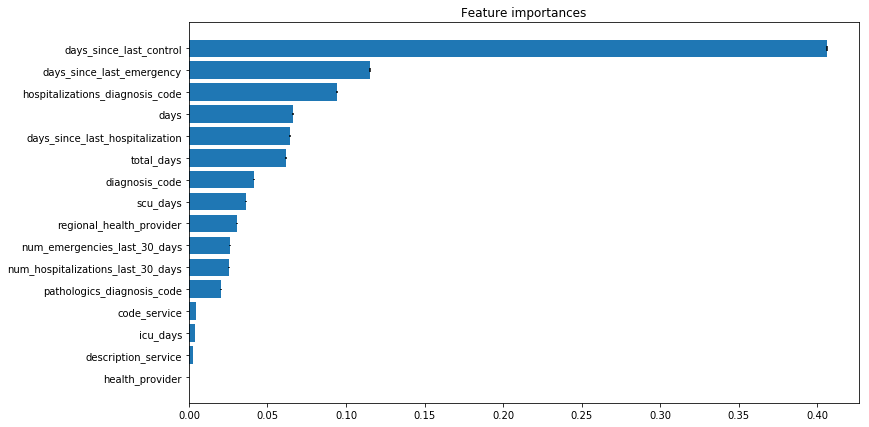

In [27]:
importances2 = clf_rf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf2.estimators_],
             axis=0)
indices2 = np.argsort(importances2)

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(12,7))
plt.title("Feature importances")
plt.barh(ho_pa_em_ad_modelable[covariates2].columns[indices2], importances2[indices2], yerr=std[indices2], align="center")
plt.show()

# Train and test sets.

In [28]:
ho_pa_em_ad_modelable_train = ho_pa_em_ad_modelable[ho_pa_em_ad_modelable['survey_date'] < "2020-01-01"]
ho_pa_em_ad_modelable_test = ho_pa_em_ad_modelable[ho_pa_em_ad_modelable['survey_date'] > "2019-12-31"]

display(ho_pa_em_ad_modelable_train)
display(ho_pa_em_ad_modelable_test)


,id_patient,survey_date,registration_date,update_date,start_date,in_date,qualitative_result,days_since_last_control,ongoing_adherence_percentage,num_reports,regional_health_provider,code_service,description_service,diagnosis_code,health_provider,pathologics_diagnosis_code,hospitalizations_diagnosis_code,icu_days,scu_days,days,out_date,days_since_last_hospitalization,num_hospitalizations_last_30_days,total_days,days_since_last_emergency,num_emergencies_last_30_days
0,500547,2016-07-11,2019-06-13,2016-08-04,2014-10-22,2015-10-04,1,0.0,100,1,6,0,0.0,2,1,247,227,0.0,0.0,3.0,2015-10-07,0.0,0.0,0.0,0.0,0.0
1,500547,2016-07-11,2019-06-13,2016-08-04,2014-10-22,2015-10-07,1,0.0,100,1,6,0,0.0,2,1,247,227,0.0,0.0,7.0,2015-10-14,0.0,0.0,0.0,0.0,0.0
2,500547,2016-07-11,2019-06-13,2019-03-14,2015-05-05,2015-10-04,1,0.0,100,1,6,0,0.0,2,1,222,227,0.0,0.0,3.0,2015-10-07,0.0,0.0,0.0,0.0,0.0
3,500547,2016-07-11,2019-06-13,2019-03-14,2015-05-05,2015-10-07,1,0.0,100,1,6,0,0.0,2,1,222,227,0.0,0.0,7.0,2015-10-14,0.0,0.0,0.0,0.0,0.0
4,500547,2016-07-11,2019-01-04,2016-08-04,2014-10-22,2015-10-04,1,0.0,100,1,6,0,0.0,323,1,247,227,0.0,0.0,3.0,2015-10-07,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496324,1999629,2018-10-08,2019-02-06,2010-12-02,2010-08-01,NaT,1,157.0,100,3,6,1,1.0,28,1,177,-1,0.0,0.0,0.0,NaT,0.0,0.0,0.0,0.0,0.0
496325,1999629,2018-10-08,2019-02-06,2010-12-02,2002-12-01,NaT,1,157.0,100,3,6,1,1.0,28,1,153,-1,0.0,0.0,0.0,NaT,0.0,0.0,0.0,0.0,0.0
496326,1999629,2018-10-08,2019-02-06,2010-12-02,2010-12-02,NaT,1,157.0,100,3,6,1,1.0,28,1,153,-1,0.0,0.0,0.0,NaT,0.0,0.0,0.0,0.0,0.0
496327,1999629,2018-10-08,2019-02-06,2010-12-02,2010-12-02,NaT,1,157.0,100,3,6,1,1.0,28,1,177,-1,0.0,0.0,0.0,NaT,0.0,0.0,0.0,0.0,0.0


,id_patient,survey_date,registration_date,update_date,start_date,in_date,qualitative_result,days_since_last_control,ongoing_adherence_percentage,num_reports,regional_health_provider,code_service,description_service,diagnosis_code,health_provider,pathologics_diagnosis_code,hospitalizations_diagnosis_code,icu_days,scu_days,days,out_date,days_since_last_hospitalization,num_hospitalizations_last_30_days,total_days,days_since_last_emergency,num_emergencies_last_30_days
80,500547,2020-01-16,2019-06-13,2016-08-04,2014-10-22,2015-10-04,1,38.0,100,5,6,0,0.0,2,1,247,227,0.0,0.0,3.0,2015-10-07,0.0,0.0,0.0,0.0,0.0
81,500547,2020-01-16,2019-06-13,2016-08-04,2014-10-22,2015-10-07,1,38.0,100,5,6,0,0.0,2,1,247,227,0.0,0.0,7.0,2015-10-14,0.0,0.0,0.0,0.0,0.0
82,500547,2020-01-16,2019-06-13,2019-03-14,2015-05-05,2015-10-04,1,38.0,100,5,6,0,0.0,2,1,222,227,0.0,0.0,3.0,2015-10-07,0.0,0.0,0.0,0.0,0.0
83,500547,2020-01-16,2019-06-13,2019-03-14,2015-05-05,2015-10-07,1,38.0,100,5,6,0,0.0,2,1,222,227,0.0,0.0,7.0,2015-10-14,0.0,0.0,0.0,0.0,0.0
84,500547,2020-01-16,2019-01-04,2016-08-04,2014-10-22,2015-10-04,1,38.0,100,5,6,0,0.0,323,1,247,227,0.0,0.0,3.0,2015-10-07,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496309,1999536,2020-02-22,2018-07-21,2018-08-08,2015-01-23,2014-12-04,1,563.0,100,2,5,1,1.0,339,1,237,200,0.0,0.0,2.0,2014-12-06,0.0,0.0,0.0,0.0,0.0
496310,1999536,2020-02-22,2018-07-21,2018-08-08,2015-01-23,2015-08-13,1,563.0,100,2,5,1,1.0,339,1,237,200,0.0,0.0,2.0,2015-08-15,0.0,0.0,0.0,0.0,0.0
496311,1999536,2020-02-22,2018-07-21,2018-08-08,2015-01-23,2019-08-23,1,563.0,100,2,5,1,1.0,339,1,237,207,0.0,0.0,2.0,2019-08-25,0.0,0.0,0.0,0.0,0.0
496312,1999536,2020-02-22,2018-07-21,2018-08-08,2015-01-23,2011-01-11,1,563.0,100,2,5,1,1.0,339,1,237,201,0.0,0.0,3.0,2011-01-14,0.0,0.0,0.0,0.0,0.0


In [29]:
#Decision tree with covariates 2.
clf_new2 = DecisionTreeClassifier(max_depth = depth)
clf_new2 = clf_new2.fit(ho_pa_em_ad_modelable_train[covariates2], ho_pa_em_ad_modelable_train['qualitative_result'])

y_pred_train2 = clf_new2.predict(ho_pa_em_ad_modelable_train[covariates2])
y_pred_test2 = clf_new2.predict(ho_pa_em_ad_modelable_test[covariates2])

print(f"Accuracy in training set: {accuracy_score(ho_pa_em_ad_modelable_train['qualitative_result'], y_pred_train2)}")
print(f"Accuracy in the other samples: {accuracy_score(ho_pa_em_ad_modelable_test['qualitative_result'], y_pred_test2)}")

Accuracy in training set: 0.8405249293714822
Accuracy in the other samples: 0.9388727549553105


In [30]:
#Decision tree with covariates 1.
clf_new = DecisionTreeClassifier(max_depth = depth)
clf_new = clf_new.fit(ho_pa_em_ad_modelable_train[covariates1], ho_pa_em_ad_modelable_train['qualitative_result'])

y_pred_train = clf_new.predict(ho_pa_em_ad_modelable_train[covariates1])
y_pred_test = clf_new.predict(ho_pa_em_ad_modelable_test[covariates1])

print(f"Accuracy in training set: {accuracy_score(ho_pa_em_ad_modelable_train['qualitative_result'], y_pred_train)}")
print(f"Accuracy in the other samples: {accuracy_score(ho_pa_em_ad_modelable_test['qualitative_result'], y_pred_test)}")

Accuracy in training set: 0.8960057457546945
Accuracy in the other samples: 0.8268813263033242


In [31]:
#Random forest with covariates 1.
clf_rf_new = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf_new.fit(ho_pa_em_ad_modelable_train[covariates1], ho_pa_em_ad_modelable_train['qualitative_result'])

y_pred_trainr = clf_rf_new.predict(ho_pa_em_ad_modelable_train[covariates1])
y_pred_testr = clf_rf_new.predict(ho_pa_em_ad_modelable_test[covariates1])

print(f"Accuracy in training set: {accuracy_score(ho_pa_em_ad_modelable_train['qualitative_result'], y_pred_trainr)}")
print(f"Accuracy in the other samples: {accuracy_score(ho_pa_em_ad_modelable_test['qualitative_result'], y_pred_testr)}")

Accuracy in training set: 0.8855427438148513
Accuracy in the other samples: 0.941805058223137


In [32]:
#Random forest with covariates 2.
clf_rf_new2 = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf_new2.fit(ho_pa_em_ad_modelable_train[covariates2], ho_pa_em_ad_modelable_train['qualitative_result'])

y_pred_trainr2 = clf_rf_new2.predict(ho_pa_em_ad_modelable_train[covariates2])
y_pred_testr2 = clf_rf_new2.predict(ho_pa_em_ad_modelable_test[covariates2])

print(f"Accuracy in training set: {accuracy_score(ho_pa_em_ad_modelable_train['qualitative_result'], y_pred_trainr2)}")
print(f"Accuracy in the other samples: {accuracy_score(ho_pa_em_ad_modelable_test['qualitative_result'], y_pred_testr2)}")

Accuracy in training set: 0.8261540330945055
Accuracy in the other samples: 0.9535342712944427


# XGBoost

## fit model on training data with covariates 1.

In [33]:
#fit model on training data with covariates 1.
xgb_model1 = XGBClassifier(max_depth=depth, random_state=0, booster='gbtree')
xgb_model1.fit(ho_pa_em_ad_modelable_train[covariates1], ho_pa_em_ad_modelable_train['qualitative_result'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [34]:
y_pred1 = xgb_model1.predict(ho_pa_em_ad_modelable_test[covariates1])
predictions1 = [round(value) for value in y_pred1]

accuracy = accuracy_score(ho_pa_em_ad_modelable_test['qualitative_result'], predictions1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.87%


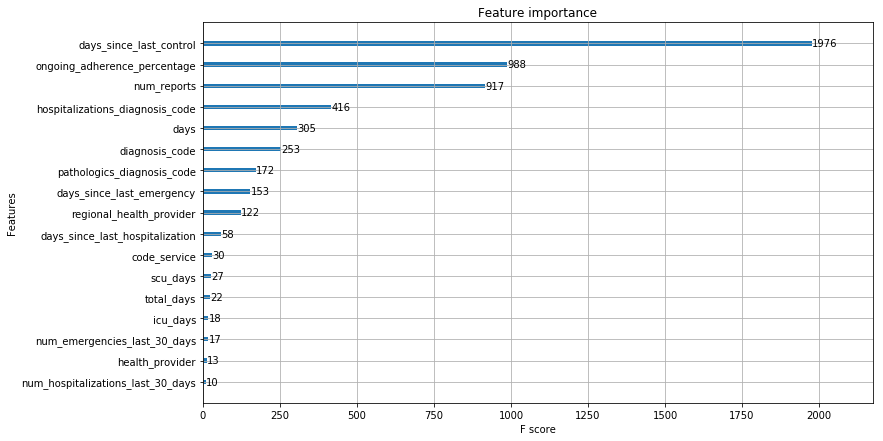

In [35]:
fig1, ax1 = plt.subplots(figsize=(12,7))
xgb.plot_importance(xgb_model1, ax=ax1)

## fit model on training data with covariates 2.

In [36]:
#fit model on training data with covariates 2.
xgb_model2= XGBClassifier(max_depth=depth, random_state=0, booster='gbtree')
xgb_model2.fit(ho_pa_em_ad_modelable_train[covariates2], ho_pa_em_ad_modelable_train['qualitative_result'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [37]:
y_pred2 = xgb_model2.predict(ho_pa_em_ad_modelable_test[covariates2])
predictions2 = [round(value) for value in y_pred2]

accuracy = accuracy_score(ho_pa_em_ad_modelable_test['qualitative_result'], predictions2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.23%


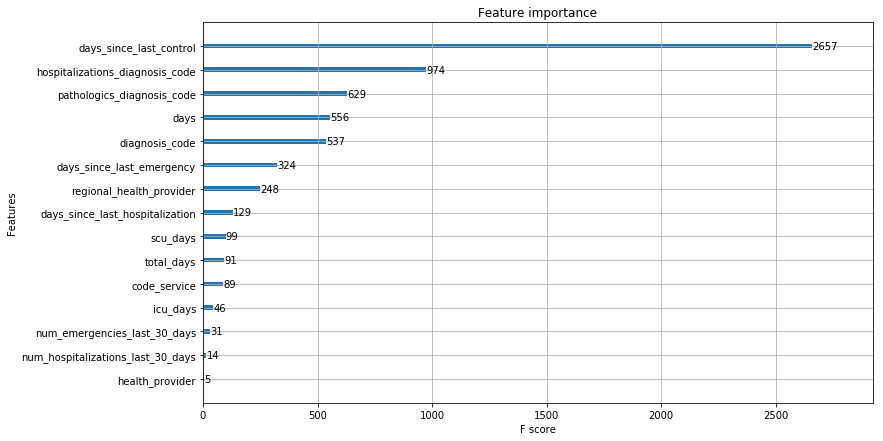

In [38]:
fig2, ax2 = plt.subplots(figsize=(12,7))
xgb.plot_importance(xgb_model2, ax=ax2)

In [39]:
params_grid = {  
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
    'max_depth': [5,6,7,8,9,10,11,12],
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
    'reg_alpha': [20, 21, 22, 23, 24, 25]
}

search_sk1 = RandomizedSearchCV(xgb_model1, params_grid, cv = 5) # 5 fold cross validation
search_sk1.fit(ho_pa_em_ad_modelable_test[covariates1], ho_pa_em_ad_modelable_test['qualitative_result'])

# best parameters
print(search_sk1.best_params_)
print(search_sk1.best_score_)

{'reg_alpha': 23, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 0.2}
0.9877632729015705


In [40]:
xgb_model_new = XGBClassifier(random_state=0, booster='gbtree', **search_sk1.best_params_)
xgb_model_new.fit(ho_pa_em_ad_modelable_train[covariates1], ho_pa_em_ad_modelable_train['qualitative_result'])

y_pred_new = xgb_model_new.predict(ho_pa_em_ad_modelable_test[covariates1])
predictions_new = [round(value) for value in y_pred_new]

accuracy = accuracy_score(ho_pa_em_ad_modelable_test['qualitative_result'], predictions_new)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.66%


In [41]:
search_sk2 = RandomizedSearchCV(xgb_model2, params_grid, cv = 5) # 5 fold cross validation
search_sk2.fit(ho_pa_em_ad_modelable_test[covariates2], ho_pa_em_ad_modelable_test['qualitative_result'])

# best parameters
print(search_sk2.best_params_)
print(search_sk2.best_score_)

{'reg_alpha': 21, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 0.2}
0.9759212789353483


In [42]:
xgb_model_new = XGBClassifier(random_state=0, booster='gbtree', **search_sk2.best_params_)
xgb_model_new.fit(ho_pa_em_ad_modelable_train[covariates2], ho_pa_em_ad_modelable_train['qualitative_result']);

y_pred_new = xgb_model_new.predict(ho_pa_em_ad_modelable_test[covariates2])
predictions_new = [round(value) for value in y_pred_new]

accuracy = accuracy_score(ho_pa_em_ad_modelable_test['qualitative_result'], predictions_new)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.99%


## Evaluate with cross validation

In [43]:
def cv_roc_tree(X, y, n_split, algo='Tree', depth=10, params={}):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        if algo == 'Tree':
            clf = DecisionTreeClassifier()
        elif algo == 'forest':
            clf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
        else:
            clf = XGBClassifier(random_state=0, booster='gbtree', verbosity=0, **params)
            
                
        clf = clf.fit(X.iloc[train], y.iloc[train])
        probas_ = clf.predict_proba(X.iloc[test])
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

Text(0.5,1,'Tree-based Classification of Non-adherent patients: 5-fold Cross-validation')

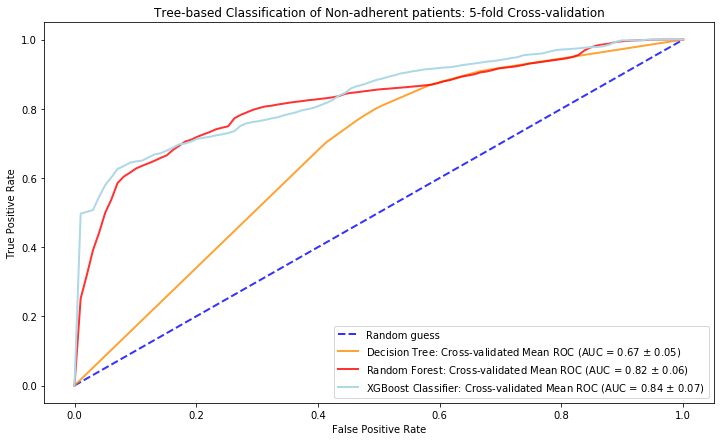

In [44]:
k_folds = 5
tprs_t, aucs_t, mean_fpr_t = cv_roc_tree(ho_pa_em_ad_modelable[covariates1], ho_pa_em_ad_modelable['qualitative_result'], k_folds, depth=depth)
tprs_f, aucs_f, mean_fpr_f = cv_roc_tree(ho_pa_em_ad_modelable[covariates1], ho_pa_em_ad_modelable['qualitative_result'], k_folds, algo='forest', depth=depth)
tprs_x, aucs_x, mean_fpr_x = cv_roc_tree(ho_pa_em_ad_modelable[covariates1], ho_pa_em_ad_modelable['qualitative_result'], k_folds, algo='xgboost', params=search_sk1.best_params_)

plt.figure(figsize=(12,7))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_t = np.mean(tprs_t, axis=0)
mean_tpr_f = np.mean(tprs_f, axis=0)
mean_tpr_x = np.mean(tprs_x, axis=0)
mean_tpr_t[-1] = 1.0
mean_tpr_f[-1] = 1.0
mean_tpr_x[-1] = 1.0

mean_auc_t = auc(mean_fpr_t, mean_tpr_t)
mean_auc_f = auc(mean_fpr_f, mean_tpr_f)
mean_auc_x = auc(mean_fpr_x, mean_tpr_x)
std_auc_t = np.std(aucs_t)
std_auc_f = np.std(aucs_f)
std_auc_x = np.std(aucs_x)

plt.plot(mean_fpr_t, mean_tpr_t, color='darkorange', lw=2, alpha=.8,
         label=f"Decision Tree: Cross-validated Mean ROC (AUC = {mean_auc_t:0.2f} $\pm$ {std_auc_t:0.2f})")
plt.plot(mean_fpr_f, mean_tpr_f, color='red', lw=2, alpha=.8,
         label=f"Random Forest: Cross-validated Mean ROC (AUC = {mean_auc_f:0.2f} $\pm$ {std_auc_f:0.2f})")
plt.plot(mean_fpr_x, mean_tpr_x, color='lightblue', lw=2, alpha=1.,
         label=f"XGBoost Classifier: Cross-validated Mean ROC (AUC = {mean_auc_x:0.2f} $\pm$ {std_auc_x:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title(f'Tree-based Classification of Non-adherent patients: {k_folds}-fold Cross-validation')

Text(0.5,1,'Tree-based Classification of Non-adherent patients: 5-fold Cross-validation')

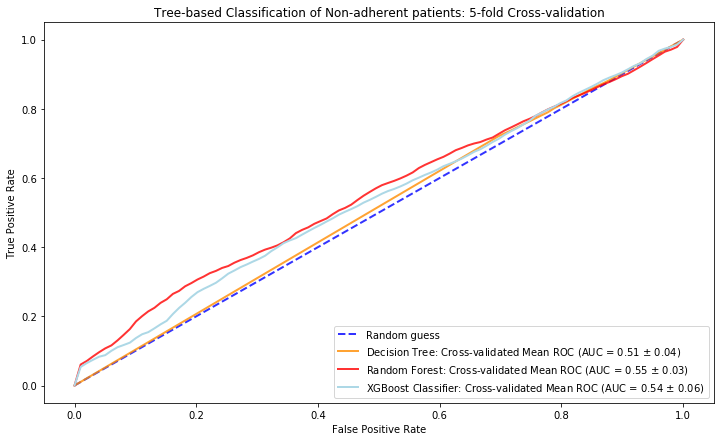

In [45]:
k_folds = 5
tprs_t, aucs_t, mean_fpr_t = cv_roc_tree(ho_pa_em_ad_modelable[covariates2], ho_pa_em_ad_modelable['qualitative_result'], k_folds, depth=depth)
tprs_f, aucs_f, mean_fpr_f = cv_roc_tree(ho_pa_em_ad_modelable[covariates2], ho_pa_em_ad_modelable['qualitative_result'], k_folds, algo='forest', depth=depth)
tprs_x, aucs_x, mean_fpr_x = cv_roc_tree(ho_pa_em_ad_modelable[covariates2], ho_pa_em_ad_modelable['qualitative_result'], k_folds, algo='xgboost', params=search_sk2.best_params_)

plt.figure(figsize=(12,7))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_t = np.mean(tprs_t, axis=0)
mean_tpr_f = np.mean(tprs_f, axis=0)
mean_tpr_x = np.mean(tprs_x, axis=0)
mean_tpr_t[-1] = 1.0
mean_tpr_f[-1] = 1.0
mean_tpr_x[-1] = 1.0

mean_auc_t = auc(mean_fpr_t, mean_tpr_t)
mean_auc_f = auc(mean_fpr_f, mean_tpr_f)
mean_auc_x = auc(mean_fpr_x, mean_tpr_x)
std_auc_t = np.std(aucs_t)
std_auc_f = np.std(aucs_f)
std_auc_x = np.std(aucs_x)

plt.plot(mean_fpr_t, mean_tpr_t, color='darkorange', lw=2, alpha=.8,
         label=f"Decision Tree: Cross-validated Mean ROC (AUC = {mean_auc_t:0.2f} $\pm$ {std_auc_t:0.2f})")
plt.plot(mean_fpr_f, mean_tpr_f, color='red', lw=2, alpha=.8,
         label=f"Random Forest: Cross-validated Mean ROC (AUC = {mean_auc_f:0.2f} $\pm$ {std_auc_f:0.2f})")
plt.plot(mean_fpr_x, mean_tpr_x, color='lightblue', lw=2, alpha=1.,
         label=f"XGBoost Classifier: Cross-validated Mean ROC (AUC = {mean_auc_x:0.2f} $\pm$ {std_auc_x:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title(f'Tree-based Classification of Non-adherent patients: {k_folds}-fold Cross-validation')

In [46]:
covariates1

Index(['days_since_last_control', 'ongoing_adherence_percentage',
       'num_reports', 'regional_health_provider', 'code_service',
       'description_service', 'diagnosis_code', 'health_provider',
       'pathologics_diagnosis_code', 'hospitalizations_diagnosis_code',
       'icu_days', 'scu_days', 'days', 'days_since_last_hospitalization',
       'num_hospitalizations_last_30_days', 'total_days',
       'days_since_last_emergency', 'num_emergencies_last_30_days'],
      dtype='object')

### Trying HumanisticModel class

In [ ]:
from external_sources_model import ExternalSourcesModel

es = ExternalSourcesModel()

# train models
rf, xg = es.train()

# dump models to disk
es.dump_models()

In [47]:
import pickle

loaded_rforest = pickle.load(open('external_sources_rforest.pkl','rb'))
loaded_xgboost = pickle.load(open('external_sources_xgboost.pkl','rb'))

In [50]:
loaded_rforest.predict(ho_pa_em_ad_modelable_test[covariates1])

array([1, 1, 1, ..., 1, 1, 1])